# Elastic Net Evaluation

This notebook trains **ElasticNet regression models per drug** using gene expression features.  
ElasticNet combines L1 (Lasso) and L2 (Ridge) regularization. We use `ElasticNetCV` to tune hyperparameters using 5-fold cross-validation.

Elastic Net combines both:
- **L1 regularization** (Lasso) → promotes sparsity
- **L2 regularization** (Ridge) → stabilizes coefficients

This allows it to both regularize and select features, making it a simple but powerful linear model.

We evaluate performance using:
- **RMSE (Root Mean Squared Error)**
- **R² (Coefficient of Determination)**

and visualize their **distribution across all drugs**.


In [1]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score, root_mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr


In [2]:
# Parameters
NUM_PCS = 30
DATA_PATH = "../../../data/processed/gdsc_pancancer_embeddings_expression_30_pcs_tissue_growth.parquet"
data = pd.read_parquet(DATA_PATH)
print("✅ Dataset loaded:", data.shape)

# Setup
os.makedirs("results/elastic_net", exist_ok=True)
non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
gene_cols = [col for col in data.columns if col not in non_features]
kf = KFold(n_splits=10, shuffle=True, random_state=42)

results = []

✅ Dataset loaded: (83624, 75)


## 1. Compute Metrics per Drug

For each drug:
- Select only rows where that drug was tested
- Split the data into training and test sets
- Fit an **Elastic Net** regressor on the PCA features
- Evaluate on test set with **RMSE** and **R²**

We only include drugs with **≥ 10 samples** to ensure meaningful evaluation.


In [3]:
from scipy.stats import pearsonr, spearmanr

# Main loop
for drug_id in sorted(data["DRUG_ID"].unique()):
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    if df.shape[0] < 100:
        continue

    X = df[gene_cols].values
    y = df["LN_IC50"].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_scaled = X_scaled.astype("float64")
    y = y.astype("float64")

    model = ElasticNetCV(
        alphas=[0.01, 0.1, 1.0, 10.0],
        l1_ratio=[0.1, 0.5, 0.9],
        cv=kf,
        max_iter=5000,
        random_state=42,
        n_jobs=-1
    )

    # Cross-validated predictions
    y_pred = cross_val_predict(model, X_scaled, y, cv=kf, n_jobs=-1)

    # Compute global metrics
    r2 = r2_score(y, y_pred)
    pearson_r, p_val = pearsonr(y, y_pred)
    spearman_r, spearman_p = spearmanr(y, y_pred)  # <-- NEW
    rmse = root_mean_squared_error(y, y_pred)

    print(f"\n🧬 Drug {drug_id} | Samples: {len(df)}")
    print(f"  ➤ Global R²: {r2:.4f}")
    print(f"  ➤ Pearson r: {pearson_r:.4f} (p={p_val:.2e})")
    print(f"  ➤ Spearman ρ: {spearman_r:.4f} (p={spearman_p:.2e})")  # <-- NEW
    print(f"  ➤ RMSE: {rmse:.4f}")
    
    results.append({
        "DRUG_ID": drug_id,
        "n_samples": len(df),
        "r2_global": r2,
        "pearson_r": pearson_r,
        "pearson_pval": p_val,
        "spearman_r": spearman_r,         # <-- NEW
        "spearman_pval": spearman_p,      # <-- NEW
        "rmse": rmse
    })



🧬 Drug 133 | Samples: 132
  ➤ Global R²: 0.1018
  ➤ Pearson r: 0.3292 (p=1.16e-04)
  ➤ Spearman ρ: 0.3226 (p=1.62e-04)
  ➤ RMSE: 1.6058

🧬 Drug 134 | Samples: 132
  ➤ Global R²: 0.1230
  ➤ Pearson r: 0.3549 (p=2.98e-05)
  ➤ Spearman ρ: 0.3680 (p=1.42e-05)
  ➤ RMSE: 1.7909

🧬 Drug 135 | Samples: 131
  ➤ Global R²: 0.0789
  ➤ Pearson r: 0.2843 (p=9.99e-04)
  ➤ Spearman ρ: 0.2963 (p=5.89e-04)
  ➤ RMSE: 2.5050

🧬 Drug 136 | Samples: 133
  ➤ Global R²: 0.0735
  ➤ Pearson r: 0.2721 (p=1.54e-03)
  ➤ Spearman ρ: 0.2194 (p=1.12e-02)
  ➤ RMSE: 1.4504

🧬 Drug 140 | Samples: 133
  ➤ Global R²: 0.0114
  ➤ Pearson r: 0.1430 (p=1.01e-01)
  ➤ Spearman ρ: 0.1565 (p=7.21e-02)
  ➤ RMSE: 1.6290

🧬 Drug 147 | Samples: 132
  ➤ Global R²: -0.0225
  ➤ Pearson r: 0.0340 (p=6.99e-01)
  ➤ Spearman ρ: 0.0754 (p=3.90e-01)
  ➤ RMSE: 0.7734

🧬 Drug 150 | Samples: 133
  ➤ Global R²: -0.0580
  ➤ Pearson r: -0.0020 (p=9.82e-01)
  ➤ Spearman ρ: 0.0239 (p=7.85e-01)
  ➤ RMSE: 0.5620

🧬 Drug 151 | Samples: 133
  ➤ Global 

In [ ]:
# Results dataframe
results_df = pd.DataFrame(results)
results_df.to_csv(f"results/elastic_net/10_fold_conc_embeddings_expression.csv", index=False)
print("📁 Saved results to results/elastic_net/elastic_net_cv_concatenated_metrics.csv")

📁 Saved results to results/elastic_net/elastic_net_cv_concatenated_metrics.csv


## 2. RMSE Distribution

We visualize the distribution of **RMSE** values across all drugs.

This shows how much prediction error the Elastic Net model makes on average, and how much it varies between drugs.


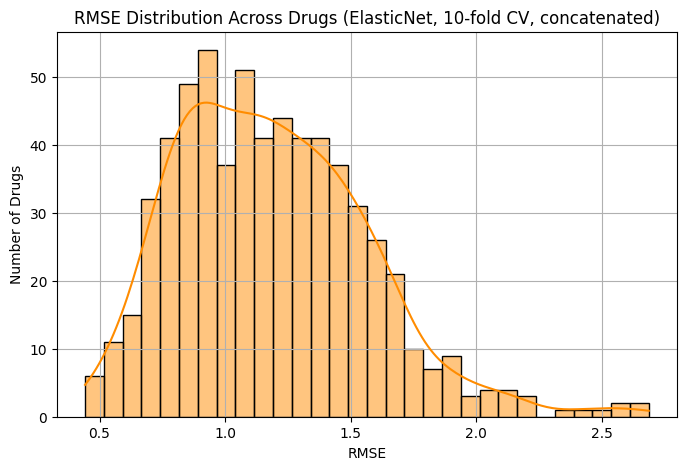

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt          # <-- correct
from scipy.stats import pearsonr, spearmanr

results_df = pd.read_csv("results/elastic_net/voom_bulk_10_fold_30_pcs_tissue_growth.csv")
# Visualization: RMSE
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse"], kde=True, bins=30, color="darkorange")
plt.title(f"RMSE Distribution Across Drugs (ElasticNet, 10-fold CV, concatenated)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()
plt.close()

## 3. R² Distribution

This distribution shows how well Elastic Net explains the variance in IC50 values.

- **R² > 0** means the model is better than the mean predictor
- **R² = 1** would be a perfect model
- Drugs with **R² close to or < 0** may not be predictable using current features


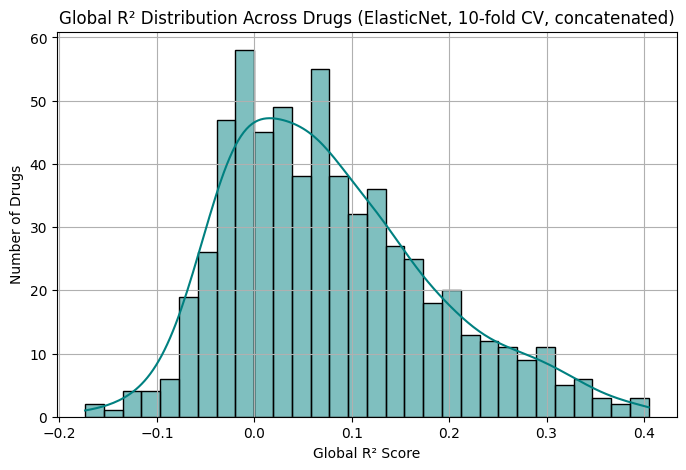

In [2]:
# Visualization: R²
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_global"], kde=True, bins=30, color="teal")
plt.title(f"Global R² Distribution Across Drugs (ElasticNet, 10-fold CV, concatenated)")
plt.xlabel("Global R² Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()
plt.close()

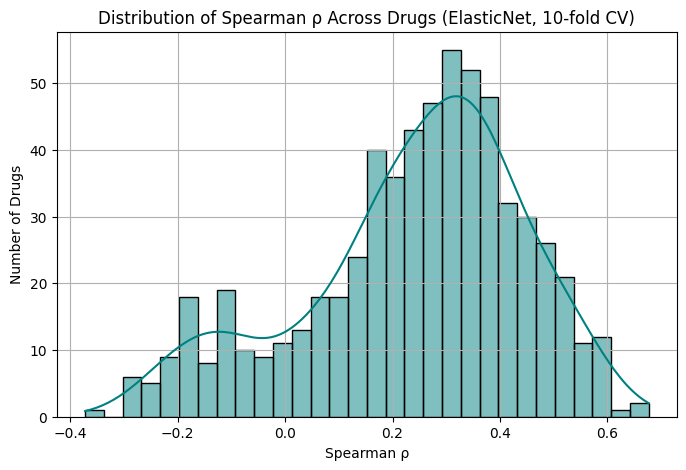

In [3]:

plt.figure(figsize=(8, 5))
sns.histplot(results_df["spearman_r"], kde=True, bins=30, color="teal")
plt.title("Distribution of Spearman ρ Across Drugs (ElasticNet, 10-fold CV)")
plt.xlabel("Spearman ρ")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()
plt.close()


## 4. Summary

Elastic Net gives a more flexible alternative to linear regression models by combining L1 and L2 penalties.

From the plots above, we can see:
- The **average RMSE** and its spread across drugs
- The **R² values**, showing how well the model captures IC50 variance

This gives us a strong baseline for comparison with more complex models like XGBoost or neural networks.


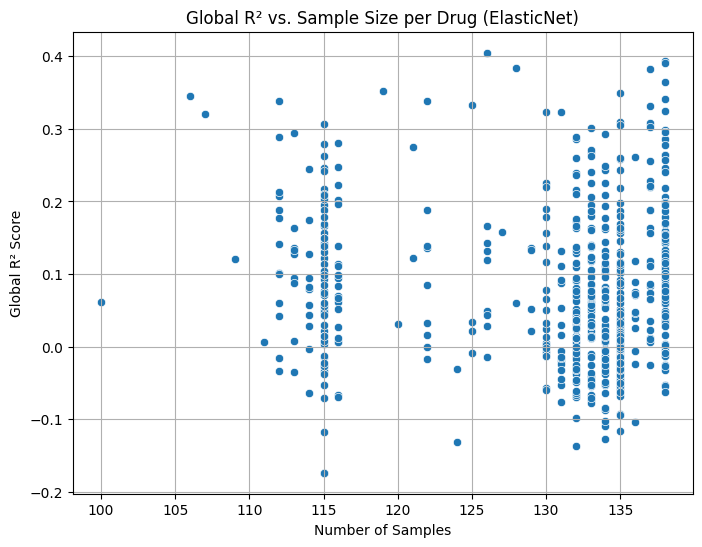

In [4]:
# Visualization: R² vs. n_samples
plt.figure(figsize=(8, 6))
sns.scatterplot(x="n_samples", y="r2_global", data=results_df)
plt.title("Global R² vs. Sample Size per Drug (ElasticNet)")
plt.xlabel("Number of Samples")
plt.ylabel("Global R² Score")
plt.grid(True)
plt.show()
plt.close()

In [5]:
# Correlations with sample size
pearson_corr, pval_pearson = pearsonr(results_df["n_samples"], results_df["r2_global"])
print(f"📊 Pearson r (samples vs R²) = {pearson_corr:.3f} (p = {pval_pearson:.3g})")

spearman_corr, pval_spearman = spearmanr(results_df["n_samples"], results_df["r2_global"])
print(f"📊 Spearman ρ (samples vs R²) = {spearman_corr:.3f} (p = {pval_spearman:.3g})")

📊 Pearson r (samples vs R²) = -0.073 (p = 0.0695)
📊 Spearman ρ (samples vs R²) = 0.006 (p = 0.881)


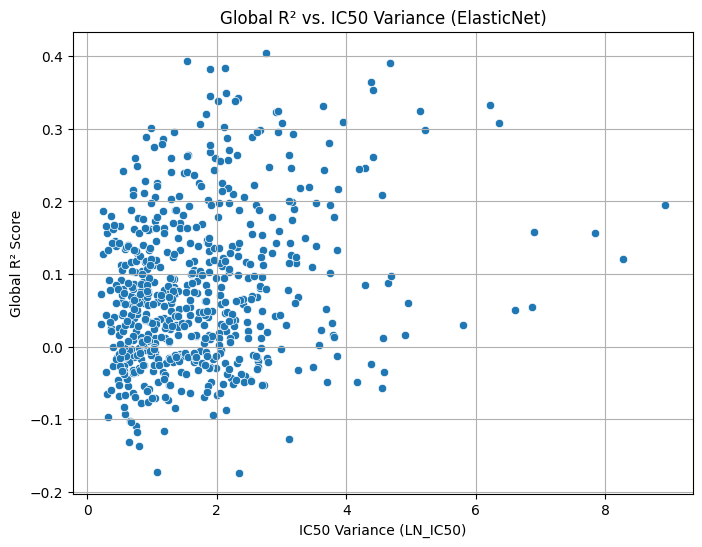

In [6]:
DATA_PATH = "../../../data/processed/gdsc_pseudobulk_voom_30_pcs_tissue_growth.parquet"
data = pd.read_parquet(DATA_PATH)

# R² vs. IC50 Variance
variances = data.groupby("DRUG_ID")["LN_IC50"].var()
results_df = results_df.merge(variances.rename("ic50_variance"), on="DRUG_ID")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="ic50_variance", y="r2_global")
plt.title("Global R² vs. IC50 Variance (ElasticNet)")
plt.xlabel("IC50 Variance (LN_IC50)")
plt.ylabel("Global R² Score")
plt.grid(True)
plt.show()
plt.close()

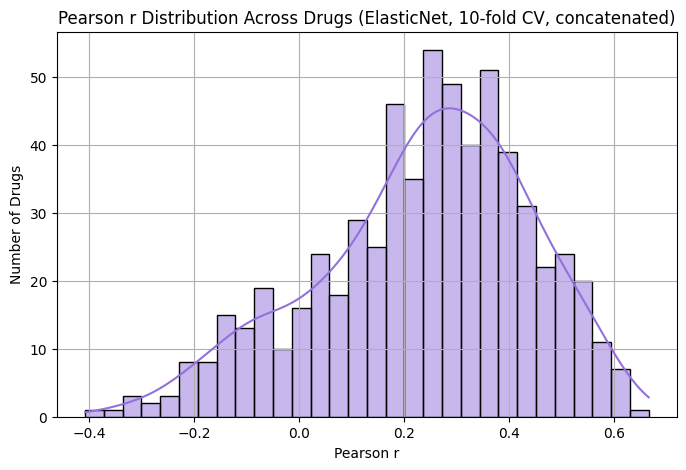

In [7]:
# 📊 Pearson r Distribution Across Drugs
plt.figure(figsize=(8, 5))
sns.histplot(results_df["pearson_r"], kde=True, bins=30, color="mediumpurple")
plt.title(f"Pearson r Distribution Across Drugs (ElasticNet, 10-fold CV, concatenated)")
plt.xlabel("Pearson r")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()
plt.close()

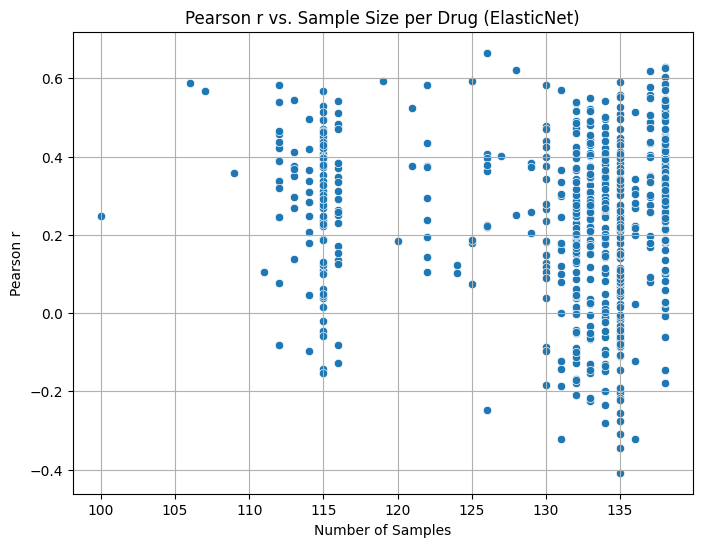

In [8]:
# 📊 Pearson r vs. Number of Samples per Drug
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="n_samples", y="pearson_r")
plt.title("Pearson r vs. Sample Size per Drug (ElasticNet)")
plt.xlabel("Number of Samples")
plt.ylabel("Pearson r")
plt.grid(True)
plt.show()
plt.close()

In [9]:
pearson_corr_r, pval_pearson_r = pearsonr(results_df["n_samples"], results_df["pearson_r"])
print(f"📊 Pearson r (samples vs Pearson r) = {pearson_corr_r:.3f} (p = {pval_pearson_r:.3g})")

spearman_corr_r, pval_spearman_r = spearmanr(results_df["n_samples"], results_df["pearson_r"])
print(f"📊 Spearman ρ (samples vs Pearson r) = {spearman_corr_r:.3f} (p = {pval_spearman_r:.3g})")


📊 Pearson r (samples vs Pearson r) = -0.102 (p = 0.0106)
📊 Spearman ρ (samples vs Pearson r) = -0.005 (p = 0.907)


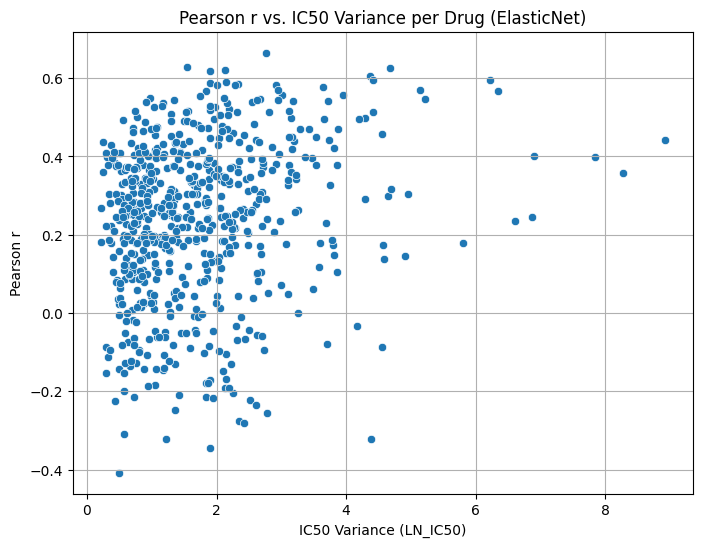

In [10]:
# 📊 Pearson r vs. IC50 Variance
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="ic50_variance", y="pearson_r")
plt.title("Pearson r vs. IC50 Variance per Drug (ElasticNet)")
plt.xlabel("IC50 Variance (LN_IC50)")
plt.ylabel("Pearson r")
plt.grid(True)
plt.show()
plt.close()

In [11]:
# 📊 Compute correlations for interpretation
pearson_corr_var, pval_pearson_var = pearsonr(results_df["ic50_variance"], results_df["pearson_r"])
print(f"📊 Pearson r (IC50 variance vs Pearson r) = {pearson_corr_var:.3f} (p = {pval_pearson_var:.3g})")

spearman_corr_var, pval_spearman_var = spearmanr(results_df["ic50_variance"], results_df["pearson_r"])
print(f"📊 Spearman ρ (IC50 variance vs Pearson r) = {spearman_corr_var:.3f} (p = {pval_spearman_var:.3g})")


📊 Pearson r (IC50 variance vs Pearson r) = 0.207 (p = 1.79e-07)
📊 Spearman ρ (IC50 variance vs Pearson r) = 0.211 (p = 1.06e-07)


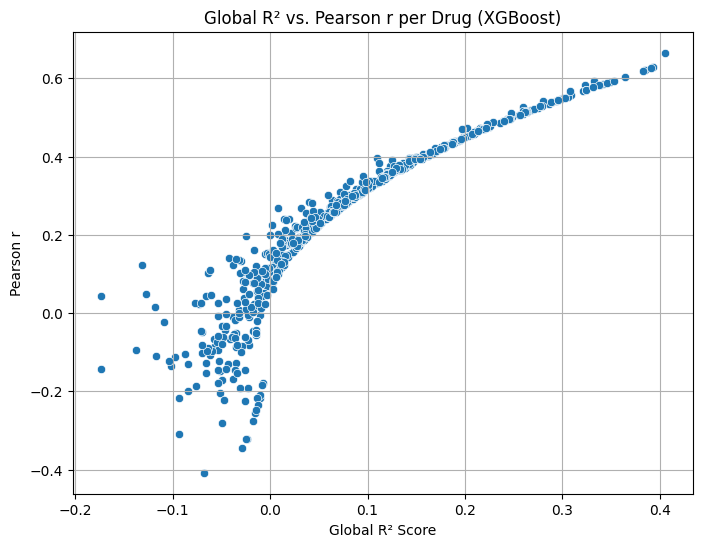

In [12]:
# 📊 Global R² vs. Pearson r consistency plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="r2_global", y="pearson_r")
plt.title("Global R² vs. Pearson r per Drug (XGBoost)")
plt.xlabel("Global R² Score")
plt.ylabel("Pearson r")
plt.grid(True)
plt.show()


In [13]:
# Correlations
from scipy.stats import spearmanr

pearson_corr_r2, pval_pearson_r2 = pearsonr(results_df["n_samples"], results_df["r2_global"])
spearman_corr_r2, pval_spearman_r2 = spearmanr(results_df["n_samples"], results_df["r2_global"])
print(f"\n📊 Pearson r (samples vs R²) = {pearson_corr_r2:.3f} (p = {pval_pearson_r2:.3g})")
print(f"📊 Spearman ρ (samples vs R²) = {spearman_corr_r2:.3f} (p = {pval_spearman_r2:.3g})")

pearson_corr_r, pval_pearson_r = pearsonr(results_df["n_samples"], results_df["pearson_r"])
spearman_corr_r, pval_spearman_r = spearmanr(results_df["n_samples"], results_df["pearson_r"])
print(f"📊 Pearson r (samples vs Pearson r) = {pearson_corr_r:.3f} (p = {pval_pearson_r:.3g})")
print(f"📊 Spearman ρ (samples vs Pearson r) = {spearman_corr_r:.3f} (p = {pval_spearman_r:.3g})")



📊 Pearson r (samples vs R²) = -0.073 (p = 0.0695)
📊 Spearman ρ (samples vs R²) = 0.006 (p = 0.881)
📊 Pearson r (samples vs Pearson r) = -0.102 (p = 0.0106)
📊 Spearman ρ (samples vs Pearson r) = -0.005 (p = 0.907)


In [14]:
from scipy.stats import pearsonr, spearmanr

# Assuming `results_df` contains columns: "ic50_variance" and "r2_global"

# 📊 Correlation between IC50 variance and R²
pearson_corr_r2, pval_pearson_r2 = pearsonr(results_df["ic50_variance"], results_df["r2_global"])
print(f"📊 Pearson r (IC50 variance vs R²) = {pearson_corr_r2:.3f} (p = {pval_pearson_r2:.3g})")

spearman_corr_r2, pval_spearman_r2 = spearmanr(results_df["ic50_variance"], results_df["r2_global"])
print(f"📊 Spearman ρ (IC50 variance vs R²) = {spearman_corr_r2:.3f} (p = {pval_spearman_r2:.3g})")


📊 Pearson r (IC50 variance vs R²) = 0.261 (p = 3.59e-11)
📊 Spearman ρ (IC50 variance vs R²) = 0.221 (p = 2.46e-08)
